In [1]:
#double run the first command if it output an error
# We download the MNIST and Fashion-MNIST datasets from torchvision and apply a simple tensor transformation.
# MNIST contains handwritten digit images, and Fashion-MNIST contains clothing images.
# Both datasets will be used for training and evaluation later.
# Important:
# - Set 'download=True' so the data will be downloaded automatically if not found locally.
# - Make sure the 'transform=transforms.ToTensor()' is used, because our models expect inputs in tensor format, not raw images.
# - The 'root' path './data' can be adjusted if you want to organize datasets differently.

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
from torch.utils.data import random_split
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

fashion_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.87MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 9.28MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 148kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]


In [3]:
# For the MNIST dataset, if print(len(mnist_train)) outputs 60000, it means the training data has been successfully downloaded as the MNIST training set officially contains 60,000 samples.

In [4]:
print(len(mnist_train))
print(len(fashion_train))

60000
60000


In [5]:
# We prepare for training by setting up the device (GPU if available, otherwise CPU),
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# We define the LeNet model architecture here.
# It consists of two convolutional layers followed by three fully connected layers, using Tanh activation functions.
# Important:
# - The input images are expected to be 28x28 grayscale images (1 input channel).
# - After two rounds of convolution and pooling, the feature map size reduces to 4x4, which matches the first Linear layer.
# - The final output layer has 10 units, corresponding to the 10 classes in MNIST and Fashion-MNIST.

In [7]:
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*4*4)
        x = self.fc(x)
        return x

In [8]:
# We extract features containing meaningful representations of the image.
# These are collected from the first fully connected layer and will be
# used to produce scatterplots.
# Note: move the tensors to CPU for compatibility with scikit-learn

In [9]:
def extract_features(model, data_loader, device):
    model.eval()
    features = []
    labels_list = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            x = model.conv(images)
            x = x.view(-1, 16*4*4)
            x = model.fc[0](x)
            features.append(x.cpu())
            labels_list.append(labels)

    return torch.cat(features), torch.cat(labels_list)

In [12]:
# We evaluate the model by graphing training loss and validation accuracy over epochs
import matplotlib.pyplot as plt

def graph_results(train_losses, val_accuracies, name="Dataset"):
  plt.figure(figsize=(10,5))
  plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training Loss over Epochs ({name.upper()})')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(f'Validation Accuracy over Epochs ({name.upper()})')
  plt.legend()
  plt.grid(True)
  plt.show()

In [14]:
# Visualize the features learned by the model by reducing them to 2D space.
# Use both PCA and t-SNE to compare linear and nonlinear projections.
# Note: We use the test set to avoid overfitting

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

def plot_feature_projection(model, test_loader, name='Dataset'):
  # Extract featured from test
  features, labels = extract_features(model, test_loader, device)

  # using PCA
  pca = PCA(n_components=2)
  features_2d_pca = pca.fit_transform(features)

  # using t-SNE instead
  tsne = TSNE(n_components=2, perplexity=30, init='pca')
  features_2d_tsne = tsne.fit_transform(features)

  # using LDA instead
  # lda = LDA(n_components=2)
  # features_2d = lda.fit_transform(features, labels)

  # create scatter plots
  plt.figure(figsize=(8,6))
  scatter = plt.scatter(features_2d_pca[:, 0], features_2d_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
  plt.title(f'PCA Projection of LeNet Features on {name.upper()} Test Set')
  plt.colorbar(scatter, ticks=range(10))
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(8,6))
  scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
  plt.title(f't-SNE Projection of LeNet Features on {name.upper()} Test Set')
  plt.colorbar(scatter, ticks=range(10))
  plt.grid(True)
  plt.show()

In [15]:
def train_and_validate(train_dataset, test_dataset, name="mnist"):
  # We split the original MNIST training dataset into a new training set (90%) and a validation set (10%).
# Important:
# - Make sure to split before training so we can properly evaluate the model on unseen data during training.
# - We manually calculate the split sizes to ensure correct proportions.
# - This split is only applied to the training set; the original test set remains untouched for final evaluation.

    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data = random_split(train_dataset, [train_size, val_size])

# We create DataLoaders for the training, validation, and test sets to efficiently load data in mini-batches.
# Important:
# - Set shuffle=True for the training DataLoader to randomize the order of samples, which helps the model generalize better.
# - Validation and test loaders use shuffle=False because we don't need to randomize data during evaluation.
# - The batch size is set to 64, but can be adjusted depending on memory and training speed.

    batch_size = 64

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initializing the LeNet model, defining the loss function, and selecting the optimizer.
# Important:
# - Always move the model to the correct device (GPU if available) before training.
# - We use CrossEntropyLoss, which is standard for multi-class classification problems like MNIST.
# - The Adam optimizer is used for faster convergence, with a learning rate of 0.001 (can be adjusted later if needed).

    model = LeNet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_accuracies = []
    num_epochs = 30

# Training LeNet on MNIST.
# Loss will drop quickly at the beginning, then stabilize around a small value.
# Validation accuracy stays around 98%-99%, meaning the model has converged.
# We run 30 epochs to ensure full convergence before stopping.

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()

        val_acc = correct / total

        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}")

# After training, we save the model's learned parameters (weights) to a file named 'lenet_mnist.pth'.
# Important:
# - We save only the model's state_dict (parameters), not the entire model structure.
# - To reuse the model later, we must first recreate the LeNet model and then load this saved state_dict.
# - Saving the model ensures we don't have to retrain from scratch every time.

    torch.save(model.state_dict(), 'lenet_mnist.pth')

# Plotting results
    graph_results(train_losses, val_accuracies, name=name)
    plot_feature_projection(model, test_loader, name=name)

Epoch [1/30], Loss: 0.3317, Val Accuracy: 0.9567
Epoch [2/30], Loss: 0.1063, Val Accuracy: 0.9740
Epoch [3/30], Loss: 0.0712, Val Accuracy: 0.9803
Epoch [4/30], Loss: 0.0551, Val Accuracy: 0.9837
Epoch [5/30], Loss: 0.0456, Val Accuracy: 0.9830
Epoch [6/30], Loss: 0.0372, Val Accuracy: 0.9835
Epoch [7/30], Loss: 0.0318, Val Accuracy: 0.9852
Epoch [8/30], Loss: 0.0271, Val Accuracy: 0.9832
Epoch [9/30], Loss: 0.0224, Val Accuracy: 0.9843
Epoch [10/30], Loss: 0.0192, Val Accuracy: 0.9838
Epoch [11/30], Loss: 0.0171, Val Accuracy: 0.9865
Epoch [12/30], Loss: 0.0158, Val Accuracy: 0.9887
Epoch [13/30], Loss: 0.0114, Val Accuracy: 0.9830
Epoch [14/30], Loss: 0.0125, Val Accuracy: 0.9837
Epoch [15/30], Loss: 0.0117, Val Accuracy: 0.9850
Epoch [16/30], Loss: 0.0103, Val Accuracy: 0.9870
Epoch [17/30], Loss: 0.0069, Val Accuracy: 0.9860
Epoch [18/30], Loss: 0.0095, Val Accuracy: 0.9867
Epoch [19/30], Loss: 0.0070, Val Accuracy: 0.9863
Epoch [20/30], Loss: 0.0078, Val Accuracy: 0.9870
Epoch [21

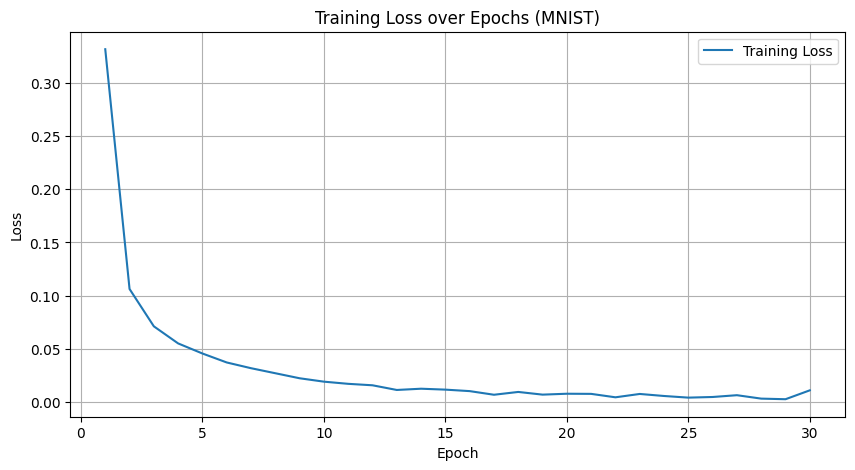

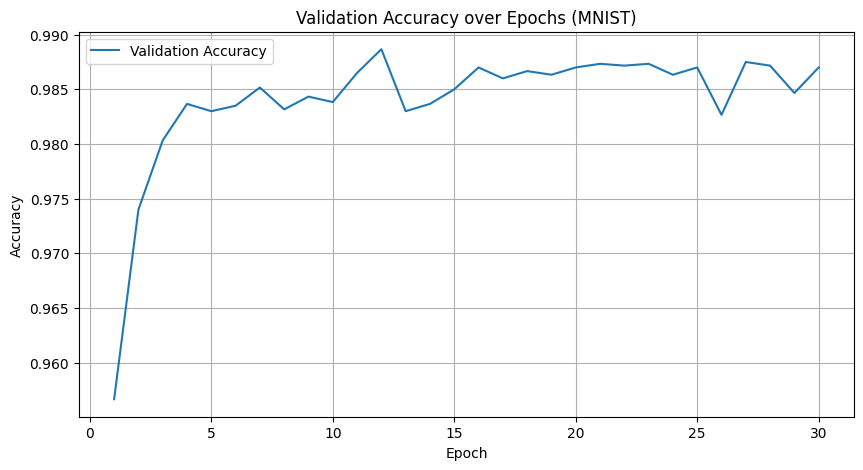

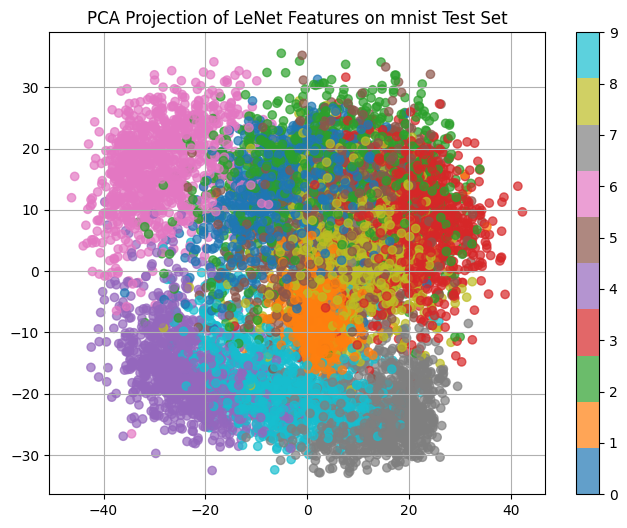

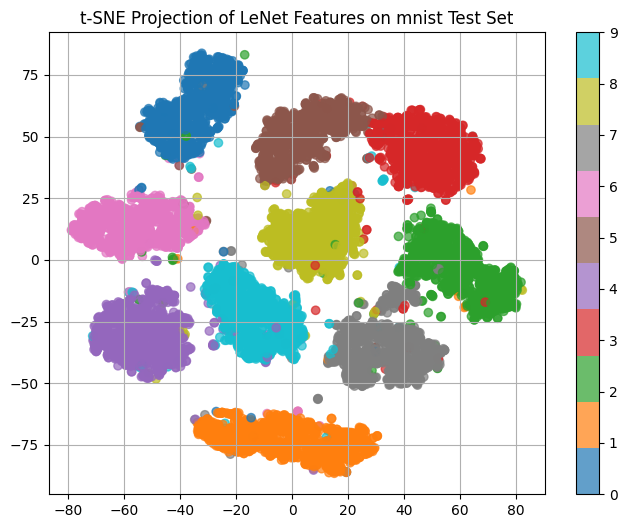

In [16]:
# MNIST dataset train/validate
train_and_validate(mnist_train, mnist_test, name="mnist")

Epoch [1/30], Loss: 0.6831, Val Accuracy: 0.8075
Epoch [2/30], Loss: 0.4574, Val Accuracy: 0.8323
Epoch [3/30], Loss: 0.3987, Val Accuracy: 0.8508
Epoch [4/30], Loss: 0.3638, Val Accuracy: 0.8687
Epoch [5/30], Loss: 0.3410, Val Accuracy: 0.8742
Epoch [6/30], Loss: 0.3216, Val Accuracy: 0.8845
Epoch [7/30], Loss: 0.3072, Val Accuracy: 0.8833
Epoch [8/30], Loss: 0.2940, Val Accuracy: 0.8820
Epoch [9/30], Loss: 0.2825, Val Accuracy: 0.8883
Epoch [10/30], Loss: 0.2723, Val Accuracy: 0.8903
Epoch [11/30], Loss: 0.2621, Val Accuracy: 0.8940
Epoch [12/30], Loss: 0.2535, Val Accuracy: 0.8897
Epoch [13/30], Loss: 0.2442, Val Accuracy: 0.8958
Epoch [14/30], Loss: 0.2363, Val Accuracy: 0.8950
Epoch [15/30], Loss: 0.2304, Val Accuracy: 0.8900
Epoch [16/30], Loss: 0.2215, Val Accuracy: 0.8970
Epoch [17/30], Loss: 0.2158, Val Accuracy: 0.8970
Epoch [18/30], Loss: 0.2081, Val Accuracy: 0.8925
Epoch [19/30], Loss: 0.2026, Val Accuracy: 0.8997
Epoch [20/30], Loss: 0.1972, Val Accuracy: 0.8988
Epoch [21

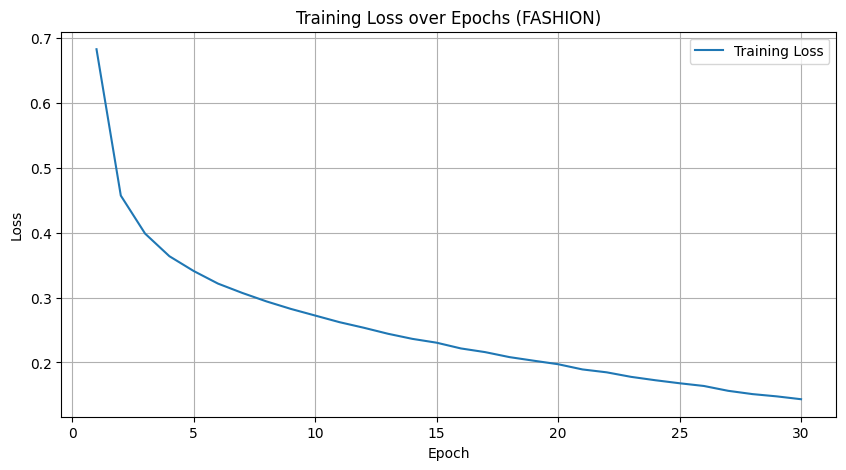

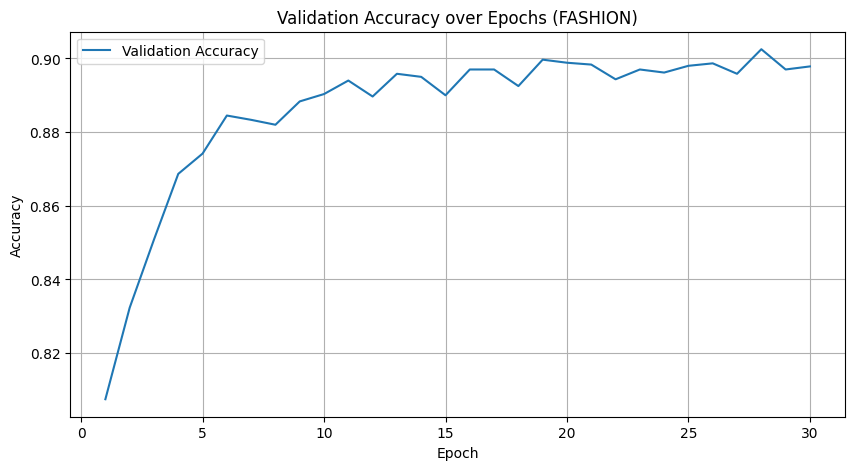

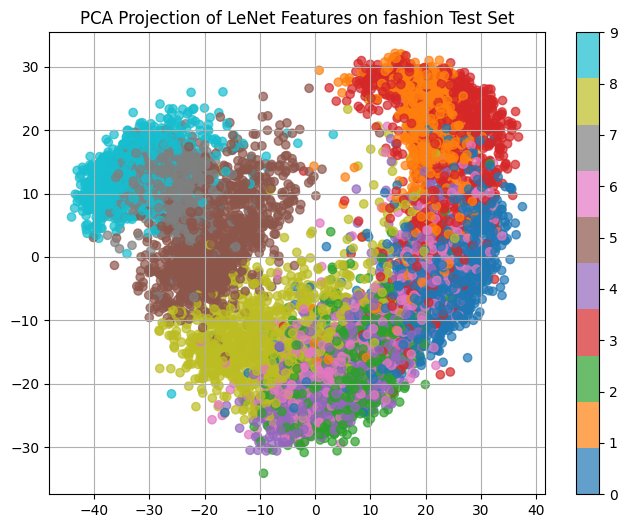

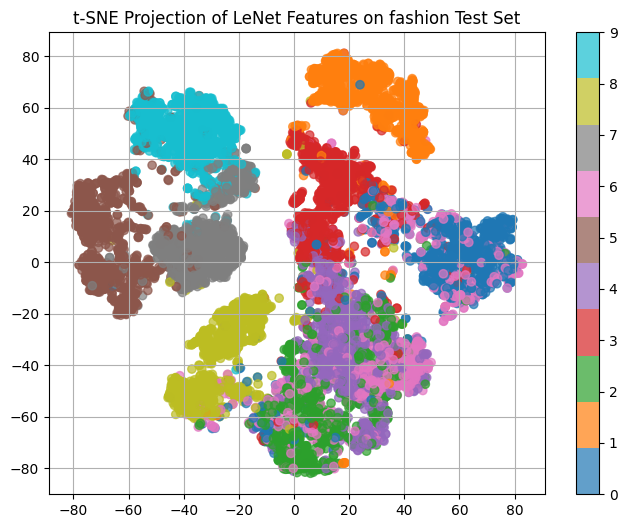

In [18]:
# Fashion-MNIST dataset train/validate
train_and_validate(fashion_train, fashion_test, name="fashion")